Image loading and pre-processing

**cite: https://www.kaggle.com/waterchiller/vgg16-classification-dog-breed**

In [1]:
from datetime import datetime
import tensorboard
import keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import cv2


In [3]:
run_name='dogmlQuickExtraTrain2'
# Define the Keras TensorBoard callback.
logdir=f"logs/{run_name}/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [4]:
BASEPATH = "./dog_data/images/Images/"
LABELS = set()

paths = []
    
for d in os.listdir(BASEPATH):
    LABELS.add(d)
    paths.append((BASEPATH+d, d))

In [5]:
# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [6]:
X = []
y = []

for path, label in paths:
    for image_path in os.listdir(path):
        image = load_and_preprocess_image(path+"/"+image_path)
        
        X.append(image)
        y.append(label)

In [7]:
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

print(y[0])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(3633, 224, 224, 3)
(3633, 20)


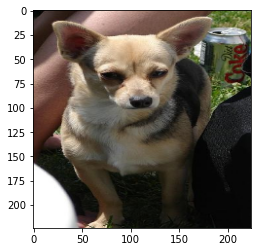

In [8]:
print(X.shape)
print(y.shape)
plt.imshow(X[0])

A create our own?
transfer learning (options: Xception/VGG16/VGG19/ResNet50)

tensorflow specific preprocessing:
notable functions 'path(s) to tensor'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)


In [10]:
model = Sequential()

model.add(Conv2D(64,(3,3),activation="softmax", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# model.add(Conv2D(64,(3,3),activation="softmax", padding="same"))
# model.add(MaxPooling2D())
# model.add(Dropout(0.2))

# model.add(Conv2D(128,(3,3),activation="softmax", padding="same"))
# model.add(MaxPooling2D())

# model.add(Conv2D(128,(3,3),activation="softmax", padding="same"))
# model.add(MaxPooling2D())

# model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(len(LABELS),activation="softmax"))
##signoid

In [11]:
#   layers.Dropout(0.2),
#   layers.Dense(16, activation='relu'),
#   layers.GlobalAveragePooling1D(),
#   layers.Dropout(0.2),
#   layers.Dense(16, activation='relu'),
#   layers.Dense(200, activation='relu'),
#   layers.Dense(16, activation='relu'),
#   layers.Dense(1, activation='sigmoid')

In [12]:
?EarlyStopping

In [13]:
early_stopping = EarlyStopping(patience=8, verbose=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=3)

In [14]:
base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
#x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
preds=Dense(len(LABELS),activation='softmax')(x)

model=Model(inputs=base_model.input,
            outputs=preds)

for layer in model.layers[:-5]:
     layer.trainable=False
for layer in model.layers[-5:]:
     layer.trainable=True
    
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [18]:
model.fit(X_train,y_train,
          batch_size=100,
          epochs=35,
          shuffle=True,
          validation_data=(X_test,y_test), 
          callbacks=[tensorboard_callback, early_stopping])

Epoch 1/35
35/35 [==============================] - 9s 248ms/step - loss: 0.4493 - accuracy: 0.8542 - val_loss: 1.2173 - val_accuracy: 0.6099
Epoch 2/35
35/35 [==============================] - 9s 248ms/step - loss: 0.4167 - accuracy: 0.8661 - val_loss: 1.2084 - val_accuracy: 0.6758
Epoch 3/35
35/35 [==============================] - 9s 249ms/step - loss: 0.2485 - accuracy: 0.9160 - val_loss: 1.3046 - val_accuracy: 0.7033
Epoch 4/35
35/35 [==============================] - 9s 248ms/step - loss: 0.1904 - accuracy: 0.9383 - val_loss: 1.4699 - val_accuracy: 0.6648
Epoch 5/35
35/35 [==============================] - 9s 250ms/step - loss: 0.1434 - accuracy: 0.9551 - val_loss: 1.3999 - val_accuracy: 0.6978
Epoch 6/35
35/35 [==============================] - 9s 249ms/step - loss: 0.1089 - accuracy: 0.9681 - val_loss: 1.4217 - val_accuracy: 0.6923
Epoch 7/35
35/35 [==============================] - 9s 252ms/step - loss: 0.0593 - accuracy: 0.9809 - val_loss: 1.5179 - val_accuracy: 0.6978
Epoch 

In [17]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

model.save(f'{run_name}_dog_model.h5')

loss on the test set is 0.95
accuracy on the test set is 0.703
